In [1]:
from copy import deepcopy

import numpy as np
from scipy.integrate import quad
from scipy.stats import norm

from matplotlib import pyplot as plt, scale as mscale, colors, cm, lines as mlines

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error, zero_one_loss

from tqdm import tqdm

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')
plt.rcParams['figure.figsize'] = [6, 2.2]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 9.5
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.2
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.edgecolor'] = '#333'
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.9
plt.rcParams['patch.linewidth'] = 0.9
plt.rcParams['hatch.linewidth'] = 0.9
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['xtick.minor.width'] = 0.6
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def generate_dist_shift(d, kP, kQ, sigma_beta=1, kappa_gamma=1, rho=1):
    
    if kP + kQ > 1:
        raise ValueError('cannot have kP + kQ > 1')
    
    dP = int(kP * d)
    dQ = int(kQ * d)
    
    SigmaP = np.ones(d) / d
    SigmaP[-dQ:] = 0
    
    beta = np.random.randn(d) * sigma_beta
    
    p = (1 / kappa_gamma - 1) / 2
    s = np.abs(beta) ** p * sigma_beta / np.sqrt(np.mean(np.abs(beta) ** (2 * (p + 1))))
    
    SigmaQ = rho * s ** 2 / d
    SigmaQ[:dP] = 0
    
    return SigmaP, SigmaQ, beta

def gen_train_test(SigmaP, SigmaQ, n_train, n_test, dPR):
    
    d = len(SigmaP)
    
    X_train = np.random.randn(n_train, dPR) * np.sqrt(SigmaP[:dPR])[None, :]
    
    X_P = np.random.randn(n_test, d) * np.sqrt(SigmaP)[None, :]
    X_Q = np.random.randn(n_test, d) * np.sqrt(SigmaQ)[None, :]
    
    return X_train, X_P, X_Q

def gen_additive_labels(*Xs, beta=None, sigma=1):
    
    if beta is None:
        raise ValueError('must supply beta')
    
    ys = []
    
    for X in Xs:
        n, d = X.shape
        # X may be only in the first subspace for training data, so clip if necessary
        beta_clip = beta[:d]
        y = X @ beta_clip + np.random.randn(n) * sigma
        ys.append(y)
        
    if len(ys) == 1:
        return ys[0]
    else:
        return ys

def gen_binary_labels(*Xs, beta=None, p_err=0):
    
    if beta is None:
        raise ValueError('must supply beta')
    
    ys = []
    
    for X in Xs:
        n, d = X.shape
        # X may be only in the first subspace for training data, so clip if necessary
        beta_clip = beta[:d]
        y = (X @ beta_clip > 0).astype(float)
        to_flip = np.random.rand(n) < p_err
        y[to_flip] = 1 - y[to_flip]
        ys.append(y)
        
    if len(ys) == 1:
        return ys[0]
    else:
        return ys

In [4]:
def train_ridge(X_train, y_train, alphas):
    
    ridge = Ridge(alpha=alphas[0], fit_intercept=False)
    
    models = []
    
    for alpha in tqdm(alphas):
        ridge.set_params(alpha=alpha)
        models.append(deepcopy(ridge.fit(X_train, y_train)))
    
    return models
    
def train_logistic_ridge(X_train, y_train, Cs):
    
    ridge = LogisticRegression(solver='lbfgs', penalty='l2', C=Cs[0], warm_start=True, fit_intercept=False)
    
    models = []
    
    for C in tqdm(Cs):
        ridge.set_params(C=C)
        models.append(deepcopy(ridge.fit(X_train, y_train)))
    
    return models

def train_to_full_coef(model, d):
    
    coef_ = model.coef_.ravel()
    dPR = len(coef_)
    
    coef = np.zeros(d)
    coef[:dPR] = coef_.copy()
    
    return coef

def eval_risks(*Xys, beta=None, metric=mean_squared_error):
    
    if beta is None:
        raise ValueError('must supply beta')
    
    risks = []
    
    for X, y in Xys:
        if metric is zero_one_loss:
            y_hat = (X @ beta > 0).astype(float)
        else:
            y_hat = X @ beta
        risk = metric(y, y_hat)
        risks.append(risk)
        
    return risks

In [5]:
d_n = 0.8
n_test = 1000
n_train = 1000
n_trials = 20
kP = 0.2
kQ = 0.1
kR = 1 - kP - kQ
sigma_beta = 1
kappa_gamma = 1
rho = 2
alphas = np.logspace(-3, 6)
sigma = np.sqrt(0.2)

np.random.seed(42)

d = int(n_train * d_n)
dQ = int(kQ * d)
dPR = d - dQ
risks_P = np.zeros((n_trials, len(alphas)))
risks_Q = np.zeros_like(risks_P)

for t in range(n_trials):
    SigmaP, SigmaQ, beta = generate_dist_shift(d, kP, kQ, sigma_beta=sigma_beta, kappa_gamma=kappa_gamma, rho=rho)
    X_train, X_P, X_Q = gen_train_test(SigmaP, SigmaQ, n_train, n_test, dPR)
    y_train = gen_additive_labels(X_train, beta=beta, sigma=sigma)
    y_P, y_Q = gen_additive_labels(X_P, X_Q, beta=beta, sigma=0)
    ridges = train_ridge(X_train, y_train, alphas)
    
    for j, ridge in enumerate(ridges):
        beta_hat = train_to_full_coef(ridge, d)
        risk_P, risk_Q = eval_risks((X_P, y_P), (X_Q, y_Q), beta=beta_hat)
        risks_P[t, j] = risk_P
        risks_Q[t, j] = risk_Q

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.81it/s]


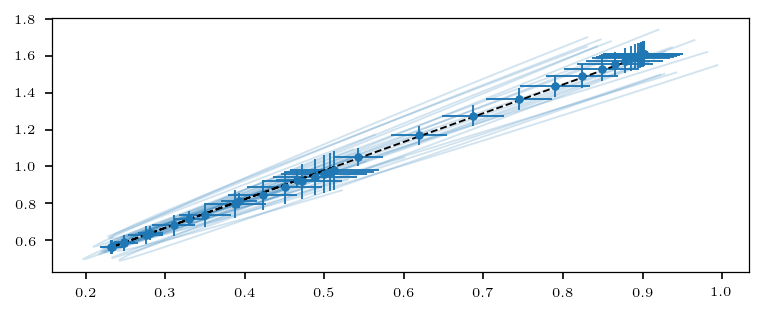

In [6]:
rP = kP + kR
gamma = kR / rP * rho
kappa = gamma * kappa_gamma
mu = (kQ + kR) / kR

mse_offset = gamma * rP * (mu - 1) * sigma_beta ** 2

for t in range(n_trials):
    plt.plot(risks_P[t, :], risks_Q[t, :], color=color_cycle[0], alpha=0.2)

R_P, R_Q = risks_P.mean(0), risks_Q.mean(0)
std_P, std_Q = risks_P.std(0), risks_Q.std(0)

plt.scatter(R_P, R_Q)
plt.errorbar(R_P, R_Q, yerr=std_Q, xerr=std_P, fmt='o')

plt.plot(R_P, gamma * R_P + mse_offset, '--k')
plt.show()

In [7]:
d_n = 0.8
n_test = 10000
n_train = 1000
n_trials = 10
kP = 0.2
kQ = 0.1
kR = 1 - kP - kQ
sigma_beta = 1
kappa_gamma = 5
rho = 2
alphas = np.logspace(-6, 9)
sigma = np.sqrt(0.0)
p_err = 0.2

np.random.seed(42)

d = int(n_train * d_n)
dQ = int(kQ * d)
dPR = d - dQ
risks_P_ridge_reg = np.zeros((n_trials, len(alphas)))
risks_Q_ridge_reg = np.zeros_like(risks_P_ridge_reg)
risks_P_ridge_bin = np.zeros_like(risks_P_ridge_reg)
risks_Q_ridge_bin = np.zeros_like(risks_P_ridge_reg)
risks_P_ridge_log = np.zeros_like(risks_P_ridge_reg)
risks_Q_ridge_log = np.zeros_like(risks_P_ridge_reg)

for t in range(n_trials):
    SigmaP, SigmaQ, beta = generate_dist_shift(d, kP, kQ, sigma_beta=sigma_beta, kappa_gamma=kappa_gamma, rho=rho)
    X_train, X_P, X_Q = gen_train_test(SigmaP, SigmaQ, n_train, n_test, dPR)
    y_train_reg = gen_additive_labels(X_train, beta=beta, sigma=sigma)
    y_train_bin = gen_binary_labels(X_train, beta=beta, p_err=p_err)
    y_P, y_Q = gen_binary_labels(X_P, X_Q, beta=beta, p_err=0)
    ridges_reg = train_ridge(X_train, y_train_reg, alphas)
    ridges_bin = train_ridge(X_train, y_train_bin, alphas)
    ridges_log = train_logistic_ridge(X_train, y_train_bin, 1 / alphas)
    
    for j, ridge in enumerate(ridges_reg):
        beta_hat = train_to_full_coef(ridge, d)
        risk_P, risk_Q = eval_risks((X_P, y_P), (X_Q, y_Q), beta=beta_hat, metric=zero_one_loss)
        risks_P_ridge_reg[t, j] = risk_P
        risks_Q_ridge_reg[t, j] = risk_Q
        
    for j, ridge in enumerate(ridges_bin):
        beta_hat = train_to_full_coef(ridge, d)
        risk_P, risk_Q = eval_risks((X_P, y_P), (X_Q, y_Q), beta=beta_hat, metric=zero_one_loss)
        risks_P_ridge_bin[t, j] = risk_P
        risks_Q_ridge_bin[t, j] = risk_Q
        
    for j, ridge in enumerate(ridges_log):
        beta_hat = train_to_full_coef(ridge, d)
        risk_P, risk_Q = eval_risks((X_P, y_P), (X_Q, y_Q), beta=beta_hat, metric=zero_one_loss)
        risks_P_ridge_log[t, j] = risk_P
        risks_Q_ridge_log[t, j] = risk_Q

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 302.95it/s]


In [8]:
rP = kP + kR
gamma = kR / rP * rho
kappa = gamma * kappa_gamma
mu = (kQ + kR) / kR

R_P = np.linspace(0, 0.5, 200)
Z = kappa_gamma * mu * np.tan(np.pi * R_P) ** 2 + mu
R_Q = np.arccos(1 / np.sqrt(Z)) / np.pi

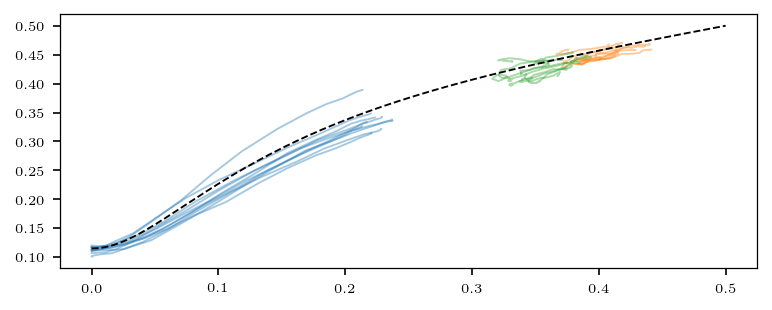

In [9]:
for t in range(n_trials):
    plt.plot(risks_P_ridge_reg[t, :], risks_Q_ridge_reg[t, :], color=color_cycle[0], alpha=0.4)

for t in range(n_trials):
    plt.plot(risks_P_ridge_bin[t, :], risks_Q_ridge_bin[t, :], color=color_cycle[1], alpha=0.4)
    
for t in range(n_trials):
    plt.plot(risks_P_ridge_log[t, :], risks_Q_ridge_log[t, :], color=color_cycle[2], alpha=0.4)
    
plt.plot(R_P, R_Q, '--k')

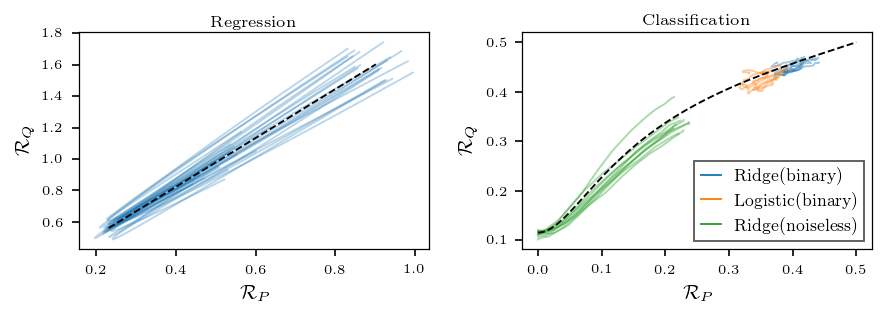

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.2))

ax = axes[0]

for t in range(risks_P.shape[0]):
    ax.plot(risks_P[t, :], risks_Q[t, :], color=color_cycle[0], alpha=0.3)
    
R_P_lin, R_Q_lin = risks_P.mean(0), risks_Q.mean(0)
std_P, std_Q = risks_P.std(0), risks_Q.std(0)

#ax.scatter(R_P, R_Q)
#ax.errorbar(R_P, R_Q, yerr=std_Q, xerr=std_P, fmt='o')
ax.set_title('Regression')
ax.set_xlabel('$\mathcal{R}_P$')
ax.set_ylabel('$\mathcal{R}_Q$')

R_P_lin = np.asarray([R_P_lin.min(), R_P_lin.max()])
ax.plot(R_P_lin, gamma * R_P_lin + mse_offset, '--k')

ax = axes[1]
    
for t in range(risks_P_ridge_reg.shape[0]):
    ax.plot(risks_P_ridge_reg[t, :], risks_Q_ridge_reg[t, :], color=color_cycle[2], alpha=0.4)
    
for t in range(risks_P_ridge_bin.shape[0]):
    ax.plot(risks_P_ridge_bin[t, :], risks_Q_ridge_bin[t, :], color=color_cycle[0], alpha=0.4)
    
for t in range(risks_P_ridge_log.shape[0]):
    ax.plot(risks_P_ridge_log[t, :], risks_Q_ridge_log[t, :], color=color_cycle[1], alpha=0.4)

ax.plot(R_P, R_Q, '--k')
ax.set_title('Classification')
ax.set_xlabel('$\mathcal{R}_P$')
ax.set_ylabel('$\mathcal{R}_Q$')

legend_labels = [
    'Ridge(binary)', 
    'Logistic(binary)',
    'Ridge(noiseless)'
]
lines = [mlines.Line2D([], [], color=color_cycle[i], marker=None, label=label) for i, label in enumerate(legend_labels)]
ax.legend(lines, legend_labels)

plt.tight_layout()
plt.savefig('simulation_risk_shifts.pdf', bbox_inches='tight')
plt.show()